In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Weddell_Extent = pd.read_excel(filepath, sheet_name='Weddell-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Weddell_Extent)
fp.date_time(Weddell_Extent)

Extent       Date
0    2136510.859 1979-01-01
1    1243495.891 1979-02-01
2    1699053.449 1979-03-01
3    2617442.085 1979-04-01
4    3852934.206 1979-05-01
..           ...        ...
533  3668127.143 2023-06-01
534  4805519.784 2023-07-01
535  5524445.234 2023-08-01
536  6006669.861 2023-09-01
537  5507961.583 2023-10-01

[538 rows x 2 columns]

In [5]:
scaler = MinMaxScaler()
Weddell_Extent['Extent'] = scaler.fit_transform(Weddell_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 12
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Weddell_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((515, 12, 1), (515,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Weddell_model_LT12/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 14s 169ms/step - loss: 0.3101 - root_mean_squared_error: 0.5568 - val_loss: 0.2345 - val_root_mean_squared_error: 0.4843
Epoch 2/50
53/53 [==============================] - 8s 144ms/step - loss: 0.1895 - root_mean_squared_error: 0.4353 - val_loss: 0.1042 - val_root_mean_squared_error: 0.3228
Epoch 3/50
53/53 [==============================] - 7s 143ms/step - loss: 0.0946 - root_mean_squared_error: 0.3076 - val_loss: 0.0927 - val_root_mean_squared_error: 0.3045
Epoch 4/50
53/53 [==============================] - 8s 147ms/step - loss: 0.0817 - root_mean_squared_error: 0.2858 - val_loss: 0.0855 - val_root_mean_squared_error: 0.2924
Epoch 5/50
53/53 [==============================] - 7s 144ms/step - loss: 0.0704 - root_mean_squared_error: 0.2653 - val_loss: 0.0672 - val_root_mean_squared_error: 0.2592
Epoch 6/50
53/53 [==============================] - 7s 135ms/step - loss: 0.0571 - root_mean_squared_error: 0.2390 - val_loss: 0.0512 - val

Epoch 31/50
53/53 [==============================] - 8s 144ms/step - loss: 0.0109 - root_mean_squared_error: 0.1042 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1051
Epoch 32/50
53/53 [==============================] - 8s 150ms/step - loss: 0.0109 - root_mean_squared_error: 0.1046 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1032
Epoch 33/50
53/53 [==============================] - 1s 24ms/step - loss: 0.0102 - root_mean_squared_error: 0.1009 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1039
Epoch 34/50
53/53 [==============================] - 7s 135ms/step - loss: 0.0113 - root_mean_squared_error: 0.1063 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1007
Epoch 35/50
53/53 [==============================] - 7s 142ms/step - loss: 0.0102 - root_mean_squared_error: 0.1008 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1002
Epoch 36/50
53/53 [==============================] - 1s 24ms/step - loss: 0.0101 - root_mean_squared_error: 0.1004 - val_loss: 0.0113 - 

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

4.299522582689921 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

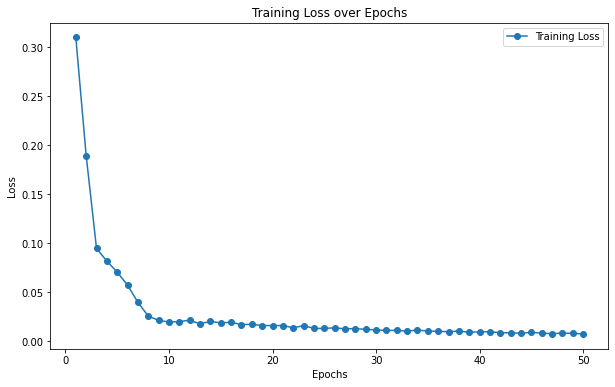

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

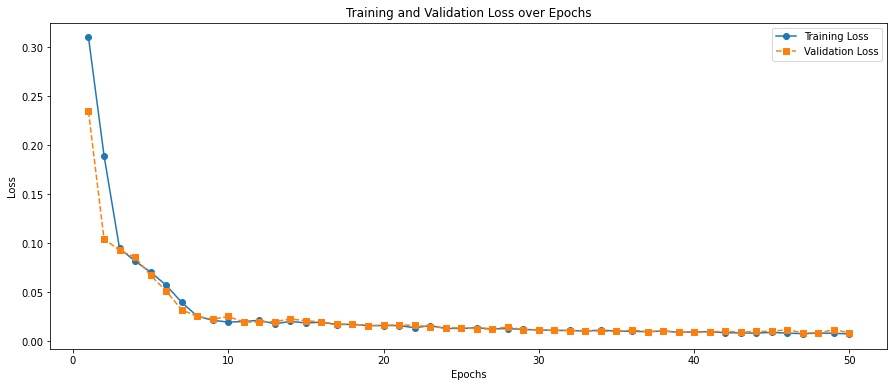

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Weddell_model_LT12/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 9ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.0792076341843738
MAE : 0.0639895322435114


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

Train Predictions  Actual Extent
0         2531747.500    2121949.701
1         3507240.500    3562381.775
2         4505801.500    5004305.983
3         5440112.500    6176613.878
4         6174916.500    6794233.093
5         6752631.500    7024136.637
6         6352474.500    6554271.388
7         5471426.000    6172281.701
8         4128948.750    4175225.799
9         2678721.000    1748380.899
10        1458399.000    1256191.080
11        1592517.875    1347295.364
12        2426740.000    2180184.677
13        3514153.500    3419295.982
14        4643733.500    4786146.771
15        5654710.500    5968132.718
16        6395934.500    6556934.174
17        6978248.000    6614949.980
18        6449399.500    6035207.368
19        5364387.500    5274244.730
20        3668596.000    3505146.372
21        1857627.375    1478130.228
22        1056226.750    1096780.503
23        1465549.125    1387234.069
24        2372743.750    2128693.591
25        3487751.250    3313318.704
26        4627284.000    4218076.656
27        5564155.000    5257641.941
28        6337560.000    5956603.340
29        6905528.500    6256062.049
30        6543976.500    5974548.305
31        5736739.500    5569396.731
32        3958271.750    3684108.410
33        2341399.000    1451614.707
34        1361813.875    1089888.684
35        1787261.000    1255222.909
36        2737711.000    1704492.279
37        3811994.750    2563551.804
38        4919975.000    3668127.143
39        5695399.000    4805519.784
40        6294806.000    5524445.234
41        6604266.000    6006669.861
42        6246413.000    5507961.583

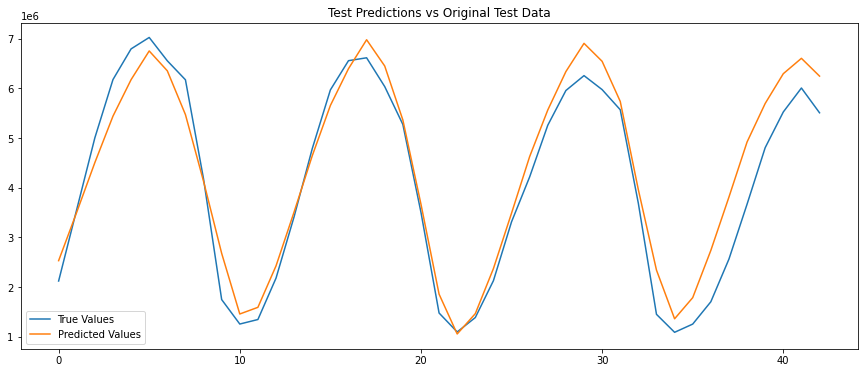

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 12ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

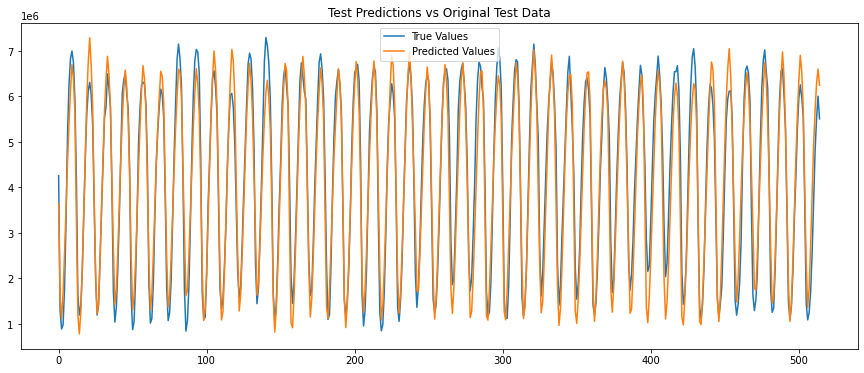

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()